In [1]:
### This notebook consists of original code used to perform the Latent Variable Analysis of CAR T-cell killing data
### as described in the associated manuscript, "Data driven model discovery and interpretation for CAR T-cell 
### killing using sparse identification and latent variables".  Produced at the end of this notebook are the
### splined interpolations of the latent variables.  Note that splining was done using functionality imported
### from the programming lanuage R, hence importing the rpy2 libary, and was done so on a 2017 Macbook Pro with an
### Intel processor, where as the current M1 processor has complications with installations of R and Python, hence 
### the import call to rpy2 being commented out currently.  Code is provided for record keeping, needs stable solution
### for M1 installation problems.

# load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pysindy as ps
import sympy as sp
import os
import csv
import math #math fun
import matplotlib.pyplot as plt #plotting
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.filterwarnings("ignore", category=ODEintWarning)
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics import mean_squared_error
from lmfit import Minimizer, minimize, Parameters, Parameter, report_fit, fit_report
from scipy.integrate import odeint, solve_ivp
from scipy import linalg, interpolate
from pylab import *


## If rpy2 and python are correctly integrated on local machine, then
## import rpy2 to perform splining procedure.  Otherwise, read in
## spreadsheets for splined data
#os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.0" # use for running on Windows machine, change path as needed
# import rpy2
# import rpy2.robjects as robjects

In [2]:
## Read in time series data for cancer cell trajcetories.  Data adapted from [1]

pbt128_data_path = 'time_series_pbt128.csv'
pbt128_data = pd.read_csv(pbt128_data_path)

In [3]:
pbt128_data

,Time (Hour),Y (E1),Y (F1),Y (G1),Y (E2),Y (F2),Y (G2)
0,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.004722,0.0021,0.0014,-0.0006,0.0003,0.0002,-0.0027
2,0.254722,-0.0036,-0.0210,-0.0408,-0.0163,-0.0328,-0.0502
3,1.289444,0.1318,0.1288,0.1329,0.1265,0.1123,0.1219
4,1.539722,0.2451,0.2124,0.2053,0.2223,0.2069,0.1904
...,...,...,...,...,...,...,...
647,163.481944,2.7498,0.8136,-0.1523,3.3272,1.2420,-0.1658
648,163.732222,2.7569,0.8189,-0.1512,3.3446,1.2385,-0.1663
649,163.982222,2.7630,0.8257,-0.1529,3.3498,1.2373,-0.1658
650,164.236667,2.7652,0.8229,-0.1510,3.3535,1.2446,-0.1666


In [4]:
## Base implementation of Taken's theorem, mutual information, and false nearest neighbors adapted from [2].
## For documentation on PySindy package, see [3-4].

## Define the Takens Theorem Embedding function
def takensEmbedding(data, delay, dimension):
    """This function returns the Takens embedding of data with delay into dimension, 
    delay*dimension must be < len(data)"""
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embeddedData;


#### Define functions for determining mutual information and false nearest neighbors.

def mutualInformation(data, delay, nBins):
    "This function calculates the mutual information given the delay"
    I = 0;
    xmax = max(data);
    xmin = min(data);
    delayData = data[delay:len(data)];
    shortData = data[0:len(data)-delay];
    sizeBin = abs(xmax - xmin) / nBins;
    #the use of dictionaries makes the process a bit faster
    probInBin = {};
    conditionBin = {};
    conditionDelayBin = {};
    for h in range(0,nBins):
        if h not in probInBin:
            conditionBin.update({h : (shortData >= (xmin + h*sizeBin)) & (shortData < (xmin + (h+1)*sizeBin))})
            probInBin.update({h : len(shortData[conditionBin[h]]) / len(shortData)});
        for k in range(0,nBins):
            if k not in probInBin:
                conditionBin.update({k : (shortData >= (xmin + k*sizeBin)) & (shortData < (xmin + (k+1)*sizeBin))});
                probInBin.update({k : len(shortData[conditionBin[k]]) / len(shortData)});
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (delayData >= (xmin + k*sizeBin)) & (delayData < (xmin + (k+1)*sizeBin))});
            Phk = len(shortData[conditionBin[h] & conditionDelayBin[k]]) / len(shortData);
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log( Phk / (probInBin[h] * probInBin[k]));
    return I;


def false_nearest_neighours(data,delay,embeddingDimension):
    "Calculates the number of false nearest neighbours of embedding dimension"    
    embeddedData = takensEmbedding(data,delay,embeddingDimension);
    #the first nearest neighbour is the data point itself, so we choose the second one
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData.transpose())
    distances, indices = nbrs.kneighbors(embeddedData.transpose())
    #two data points are nearest neighbours if their distance is smaller than the standard deviation
    epsilon = np.std(distances.flatten())
    nFalseNN = 0
    for i in range(0, len(data)-delay*(embeddingDimension+1)):
        if (0 < distances[i,1]) and (distances[i,1] < epsilon) and ( (abs(data[i+embeddingDimension*delay] - data[indices[i,1]+embeddingDimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN


## Define the Latent variable discovery and rescaling function
def latent_discovery_spline(data_arr, time_delay, dimension, nknots_arr, t_cell_arr, invert_latent, cart_scale_arr, cart_offset_arr):
    
    """This function performs the latent variable discovery, rescales the discovered variable, 
    and splines original and discovered data"""
    n_trajectories = len(data_arr)
    time_arr = []
    spline_tumor_arr = []
    spline_cart_arr = []
    
    for i in range(n_trajectories):
        data_trial = data_arr[i]
        # Offset data by negative values
        if np.min(data_trial[:,1]) < 0:
            data_trial[:,1] = data_trial[:,1] - np.min(data_trial[:,1])
        
        #embed into two dimensions
        embedded_tumor_cell = takensEmbedding(data_trial[:,1],time_delay,dimension)

        # compute SVD of embedding.
        U, s, Vh = linalg.svd(embedded_tumor_cell)
        
        ## Splining the columns of V*.  Here we employ piping the smooth.spline function from R
        t_trim = data_trial[(2*time_delay):,0]

        r_y1 = robjects.FloatVector(data_trial[(2*time_delay):,1])
        r_x1 = robjects.FloatVector(t_trim)

        r_y2 = robjects.FloatVector(Vh[:,1])
        r_x2 = robjects.FloatVector(t_trim)

        r_smooth_spline = robjects.r['smooth.spline'] #extract R function

        spline1 = r_smooth_spline(x = r_x1, y = r_y1, nknots = int(nknots_arr[i][0]))
        tumor_pyspline = np.array(robjects.r['predict'](spline1,r_x1).rx2('y'))
        spline2 = r_smooth_spline(x = r_x2, y = r_y2, nknots = int(nknots_arr[i][1]))
        cart_pyspline = np.array(robjects.r['predict'](spline2,r_x2).rx2('y'))
        
        ## Try replotting with the smooth discovered timeseries
        if cart_scale_arr is not None:
            t_cell_scale = cart_scale_arr[i]
        else:
            t_cell_scale = np.diff((t_cell_arr[i][0], t_cell_arr[i][1]))/np.diff((Vh[2,1], Vh[-1,1]))

        if invert_latent[i] == True:
            t_cell_scale = -t_cell_scale
        
        cart_offset = cart_offset_arr[i]
        
        plt.figure(figsize = (8,6), dpi = 600)
        plt.plot(data_trial[:,0], data_trial[:,1], 'ro', label = 'Measured Cancer Cells', alpha = 0.5)
        plt.plot(t_trim, tumor_pyspline, 'k-', label = 'Splined Measured Cancer Cells')
        plt.plot(t_trim, t_cell_scale*Vh[:,1]+cart_offset, 'yo', label = 'Latent CAR T-cells', alpha = 0.5)
        plt.plot(t_trim, t_cell_scale*cart_pyspline+cart_offset, 'b-', label = 'Splined-Latent CAR T-cells')
        plt.plot([data_trial[0,0], data_trial[-1,0]], [t_cell_arr[i][0],  t_cell_arr[i][1]], 'ko', 
                 label = 'Measured CAR T-cells', markersize = 12)
#        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True)
#         if i==0:
        plt.legend(fontsize = 18)
        plt.xlabel('Time (Hours)', fontsize = 18)
        plt.ylabel('Cell Index (CI)', fontsize = 18)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.ylim(0,4.25)
        plt.savefig("/Users/alexwork/Desktop/splined_latent_high" + str(i)+".png")
        plt.show()
        
        if np.min(tumor_pyspline) < 0:
            tumor_pyspline = tumor_pyspline - np.min(tumor_pyspline)
        
        time_arr.append(t_trim)
        spline_tumor_arr.append(tumor_pyspline)
        spline_cart_arr.append(t_cell_scale*cart_pyspline+cart_offset)
    
    ## Now stack splined data with checking for negative values in tumor line
    trials_arr = []
    for i in range(len(time_arr)):
        trials_arr.append(np.stack((spline_tumor_arr[i], spline_cart_arr[i]), axis = -1))
    
    
    return time_arr, trials_arr



## Here we define the progress tracking functions as in the pysindy documentation
## but with the added condition of analyzing trajectories

def plot_x_dot_fits(x_test_arr, optimizer, t_test_arr, t_forward_arr):
    n_models = len(optimizer.history_)
    n_trajectories = len(x_test_arr)
    
    plt.figure(figsize = (20,10))
    gs = gridspec.GridSpec(n_trajectories, n_models)
    gs.update(wspace=0.0, hspace=0.0) # sets the spacing between axes
    
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j,:,:]
        
        x_dot_test_predicted = model.predict(x_test_arr, multiple_trajectories = True)
        x_dot_test_computed = model.differentiate(x_test_arr, t=t_test_arr, multiple_trajectories = True)
        
        for i in range(n_trajectories):
            plt.subplot(gs[i,j])
            plt.plot(t_test_arr[i], x_dot_test_computed[i][:,0],
                    'k', label = 'Cancer cells numerical derivative')
            plt.plot(t_test_arr[i], x_dot_test_predicted[i][:,0],
                    'r', label = 'Cancer cells model prediction')
            plt.plot(t_test_arr[i], x_dot_test_computed[i][:,1],
                    'b', label = 'CAR T cells numerical derivative')
            plt.plot(t_test_arr[i], x_dot_test_predicted[i][:,1],
                    'm', label = 'CAR T cells model prediction')
            
            if j == 0:
                plt.ylabel('Trajectory ' +  str(i+1) + '\n time derivatives', fontsize = 20)
            if i == 0:
                plt.title('MSE = %0.f' % model.score(x_test_arr, t=t_test_arr, 
                                                     metric = mean_squared_error, 
                                                     multiple_trajectories = True),
                         fontsize = 16)
            plt.xlabel('Model ' + str(j), fontsize = 16)
            plt.xticks(fontsize = 18)
            plt.yticks(fontsize = 18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)
            if j == (n_models-1):
                plt.legend(loc = 'upper right')

        model.print()
        print('Model ' + str(j) + ', MSE: %f' % model.score(x_test_arr, t=t_test_arr,
                                                           metric = mean_squared_error,
                                                           multiple_trajectories = True))
    
    ax.set_yticklabels([])
    plt.show()

def plot_x_fits(x_test_arr, optimizer, t_test_arr, t_forward_arr):
    n_models = len(optimizer.history_)
    n_trajectories = len(x_test_arr)
    
    plt.figure(figsize = (20,10))
    gs = gridspec.GridSpec(n_trajectories, n_models)
    gs.update(wspace=0.0, hspace=0.0) # sets the spacing between axes

    score = []
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j,:,:]

        x_test_sim_arr = []
        x_forward_sim_arr = []
        pred_rmse = 0
        for i in range(n_trajectories):
            x_test_sim_arr.append(model.simulate(x_test_arr[i][0,:], t_test_arr[i],
                                                integrator = 'odeint'))
            x_forward_sim_arr.append(model.simulate(x_test_arr[i][0,:], t_forward_arr[i],
                                                integrator = 'odeint'))
            pred_rmse = (pred_rmse + np.sum(np.square(x_test_sim_arr[i] - data[i])))*0.5
            score.append(pred_rmse)

        
        for i in range(n_trajectories):
            plt.subplot(gs[i,j])
            plt.plot(t_test_arr[i], data[i][:,0],
                    'k.', label = 'Cancer cells measured')
            if np.max(np.abs(pred_rmse)) < 5000:
                plt.plot(t_forward_arr[i], x_forward_sim_arr[i][:,0],
                        'r-.', label = 'Cancer cells predicted')
            plt.plot(t_test_arr[i], data[i][:,1],
                    'b.', label = 'CAR T cells latent measured')
            if np.max(np.abs(pred_rmse)) < 5000:
                plt.plot(t_forward_arr[i], x_forward_sim_arr[i][:,1],
                        'm-.', label = 'CAR T cells predicted')

                
            if j == 0:
                plt.ylabel('Trajectory ' +  str(i+1), fontsize = 20)
            if i == 0:
                if np.max(np.abs(pred_rmse)) < 5000:
                    plt.title('MSE = %0.f' % pred_rmse,
                             fontsize = 16)
                else:
                    plt.title('MSE too large')
                    
            plt.xlabel('Model ' + str(j), fontsize = 16)
            plt.xticks(fontsize = 18)
            plt.yticks(fontsize = 18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)
            if j == (n_models-1):
                plt.legend(loc = 'upper right')
        
        model.print()
        print('Model ' + str(j) + ', MSE: %f' % pred_rmse)
        
    ax.set_yticklabels([])
    plt.show()

In [5]:
### Here we extract arrays of data for analysis.
### Note that CAR T-cell populations are hard coded, with
### values drawn from the CAR_T_cell_measurements.xlsx file.

## Extracting the G columns of PBT128
start_tG = [120, 120]
end_tG = [652, 652]
data_columnG = ['Y (G1)', 'Y (G2)']
t_cell_startG = [0.25, 0.25]
t_cell_endG = [0.5681, 0.5479]

## Extracting the F columns of PBT128
start_tF = [125, 125]
end_tF = [652, 652]
data_columnF = ['Y (F1)', 'Y (F2)']
t_cell_startF = [0.125, 0.125]
t_cell_endF = [0.372, 0.2692]

## Extracting the E columns of PBT128
start_tE = [125, 125]
end_tE = [652, 652]
data_columnE = ['Y (E1)', 'Y (E2)']
t_cell_startE = [0.05, 0.05]
t_cell_endE = [0.1984, 0.2344]


In [62]:
##################################################################
##################################################################
#### Here are initializations of data for PBT128, two trials. ####
##################################################################
##################################################################

## Analysis is conducted one dataset at a time.  So, to change
## which data set is being analyzed, simply uncomment the 
## initialization block that you wish to study and comment out
## the remaining blocks.


# # Initializing E columns
Es_trial1 = np.array(pbt128_data[['Time (Hour)', data_columnE[0]]])[start_tE[0]:end_tE[0],:]
Es_trial2 = np.array(pbt128_data[['Time (Hour)', data_columnE[1]]])[start_tE[1]:end_tE[1],:]
data_trajectories = np.array([Es_trial1, Es_trial2])
t_cell_arr = np.array([[t_cell_startE[0], t_cell_endE[0]], 
                     [t_cell_startE[1], t_cell_endE[1]]])
cart_scale_arr = np.array([[1.25], [1.25]])  # here we specify the re-scaling factor for the latent variable CAR T-cells
cart_offset_arr = np.array([[0.2], [0.2]])  # here we specify the offset value for the latent variable CAR T-cells
invert_latent = [False, False]
nknots_arr = np.array([[8,5],[5,5]])  # here we specify the number of knots to use when splining the cancer cell data and CAR T-cell data, respectively
                                        
    
    

# Initializing F columns
# Fs_trial1 = np.array(pbt128_data[['Time (Hour)', data_columnF[0]]])[start_tF[0]:end_tF[0],:]
# Fs_trial2 = np.array(pbt128_data[['Time (Hour)', data_columnF[1]]])[start_tF[1]:end_tF[1],:]
# data_trajectories = np.array([Fs_trial1, Fs_trial2])
# t_cell_arr = np.array([[t_cell_startF[0], t_cell_endF[0]], 
#                      [t_cell_startF[1], t_cell_endF[1]]])
# cart_scale_arr = np.array([[1.5], [2]])     # here we specify the re-scaling factor for the latent variable CAR T-cells
# cart_offset_arr = np.array([[0.4], [0.425]])  # here we specify the offset value for the latent variable CAR T-cells
# invert_latent = [False, False]
# nknots_arr = np.array([[6,4],[6,4]])  # here we specify the number of knots to use when splining the cancer cell data and CAR T-cell data, respectively
    
    

# Initializing G columns
# Gs_trial1 = np.array(pbt128_data[['Time (Hour)', data_columnG[0]]])[start_tG[0]:end_tG[0],:]
# Gs_trial2 = np.array(pbt128_data[['Time (Hour)', data_columnG[1]]])[start_tG[1]:end_tG[1],:]
# data_trajectories = np.array([Gs_trial1, Gs_trial2])
# t_cell_arr = np.array([[t_cell_startG[0], t_cell_endG[0]], 
#                     [t_cell_startG[1], t_cell_endG[1]]])
# cart_scale_arr = np.array([[1.5], [1.5]])   # here we specify the re-scaling factor for the latent variable CAR T-cells
# cart_offset_arr = np.array([[0.55], [0.55]])  # here we specify the offset value for the latent variable CAR T-cells
# invert_latent = [False, False]
# nknots_arr = np.array([[20,5],[20,5]])  # here we specify the number of knots to use when splining the cancer cell data and CAR T-cell data, respectively
                                        




print(data_trajectories)

[[[ 32.837222   1.2445  ]
  [ 33.087222   1.27    ]
  [ 33.3375     1.2992  ]
  ...
  [163.982222   2.763   ]
  [164.236667   2.7652  ]
  [164.490556   2.7645  ]]

 [[ 32.837222   1.2689  ]
  [ 33.087222   1.2873  ]
  [ 33.3375     1.3117  ]
  ...
  [163.982222   3.3498  ]
  [164.236667   3.3535  ]
  [164.490556   3.3509  ]]]


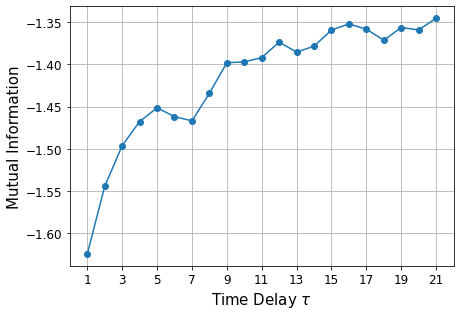

In [63]:
## Here we perform the mutual information calculation to determine the appropriate time delay.

datDelayInformation = []
for i in range(1,22):
    datDelayInformation = np.append(datDelayInformation,[mutualInformation(Gs_trial2[:,1],i,16)])

fig, ax = plt.subplots(figsize = (6.5,4.5))
plt.plot(range(1,22),datDelayInformation, 'o-');
plt.xlabel('Time Delay '+r'$\tau$', fontsize = 15);
plt.ylabel('Mutual Information', fontsize = 15);
plt.xticks(fontsize = 12)
ax.set_xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
plt.yticks(fontsize = 12)
plt.xlim(0,22)
plt.grid()
plt.tight_layout()
plt.show()

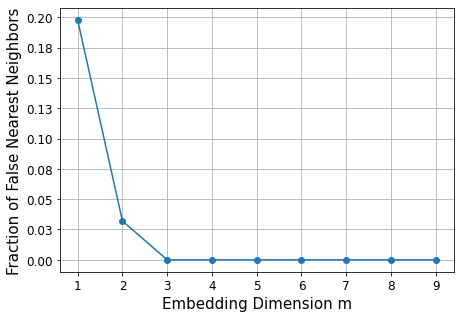

In [64]:
## Here we perform the flase nearest neighbors search to determine the appropriate embedding dimension.

nFNN = []
for i in range(1,10):
    nFNN.append(false_nearest_neighours(Gs_trial2[:,1],1,i) / len(Gs_trial2[:,1]))
    
fig, ax = plt.subplots(figsize = (6.5,4.5))    
plt.plot(range(1,10),nFNN, 'o-');
plt.xlabel('Embedding Dimension m', fontsize = 15);
plt.ylabel('Fraction of False Nearest Neighbors', fontsize = 15);
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.grid()
plt.tight_layout()
plt.show()

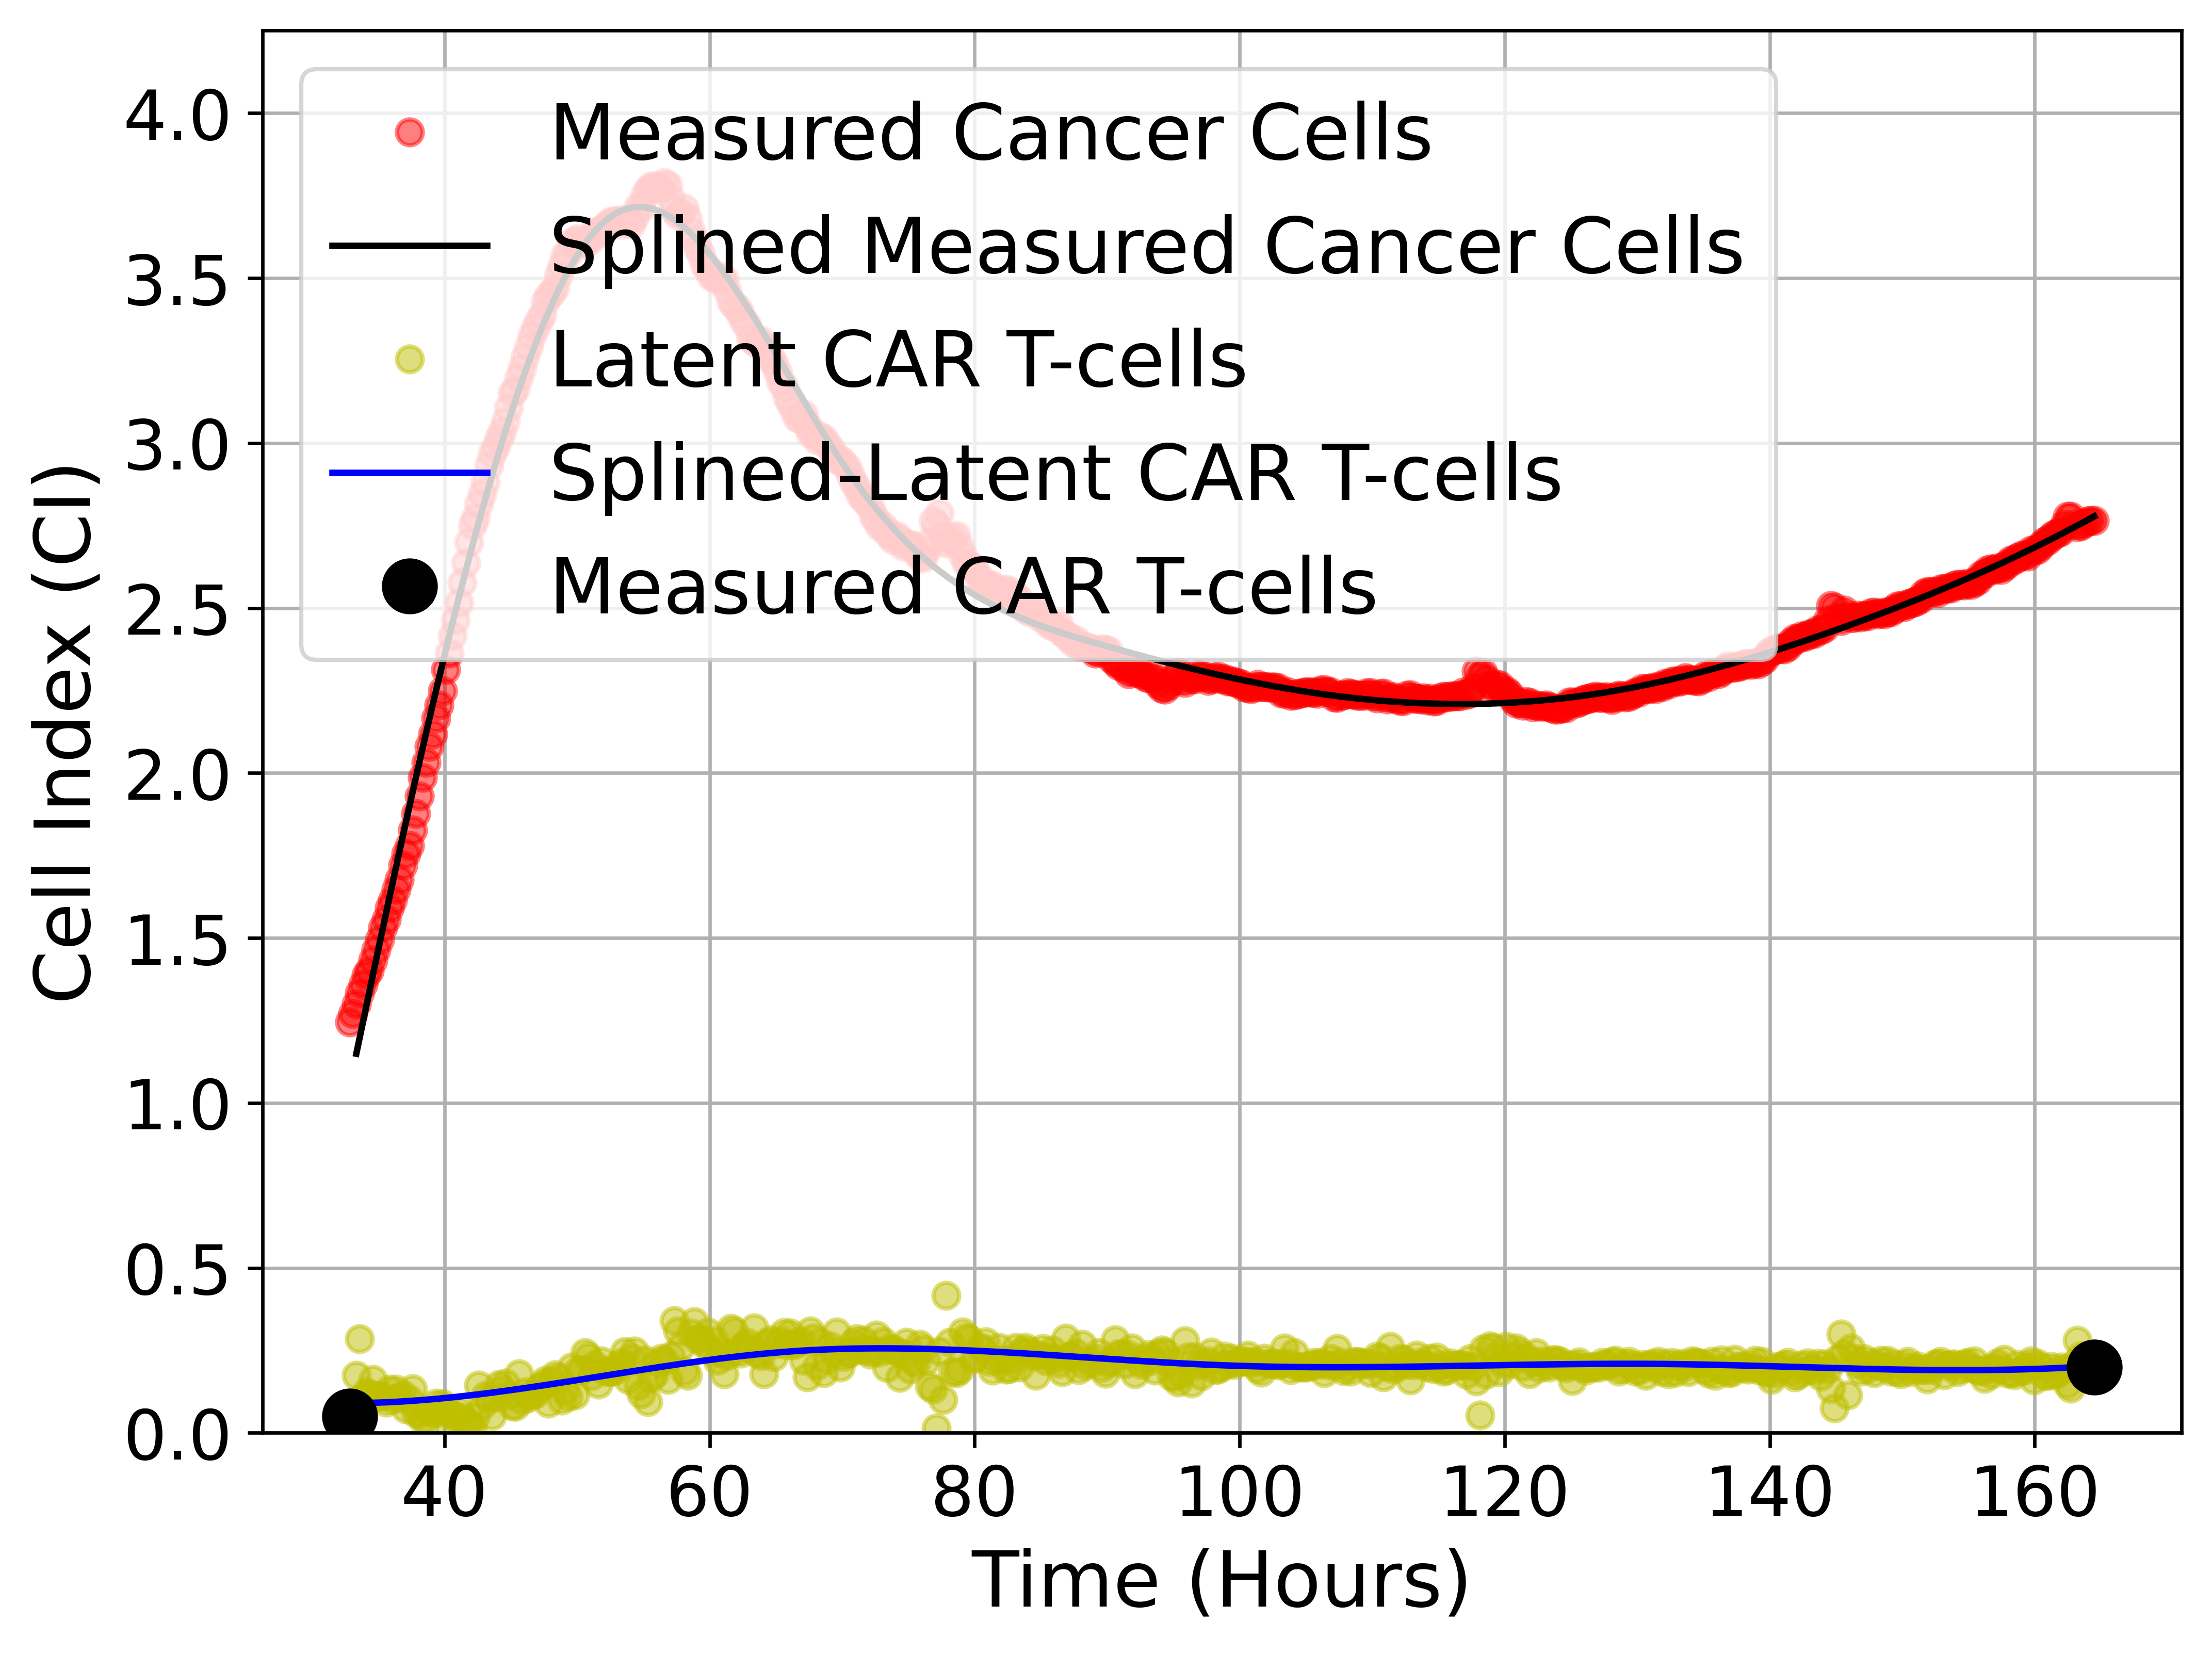

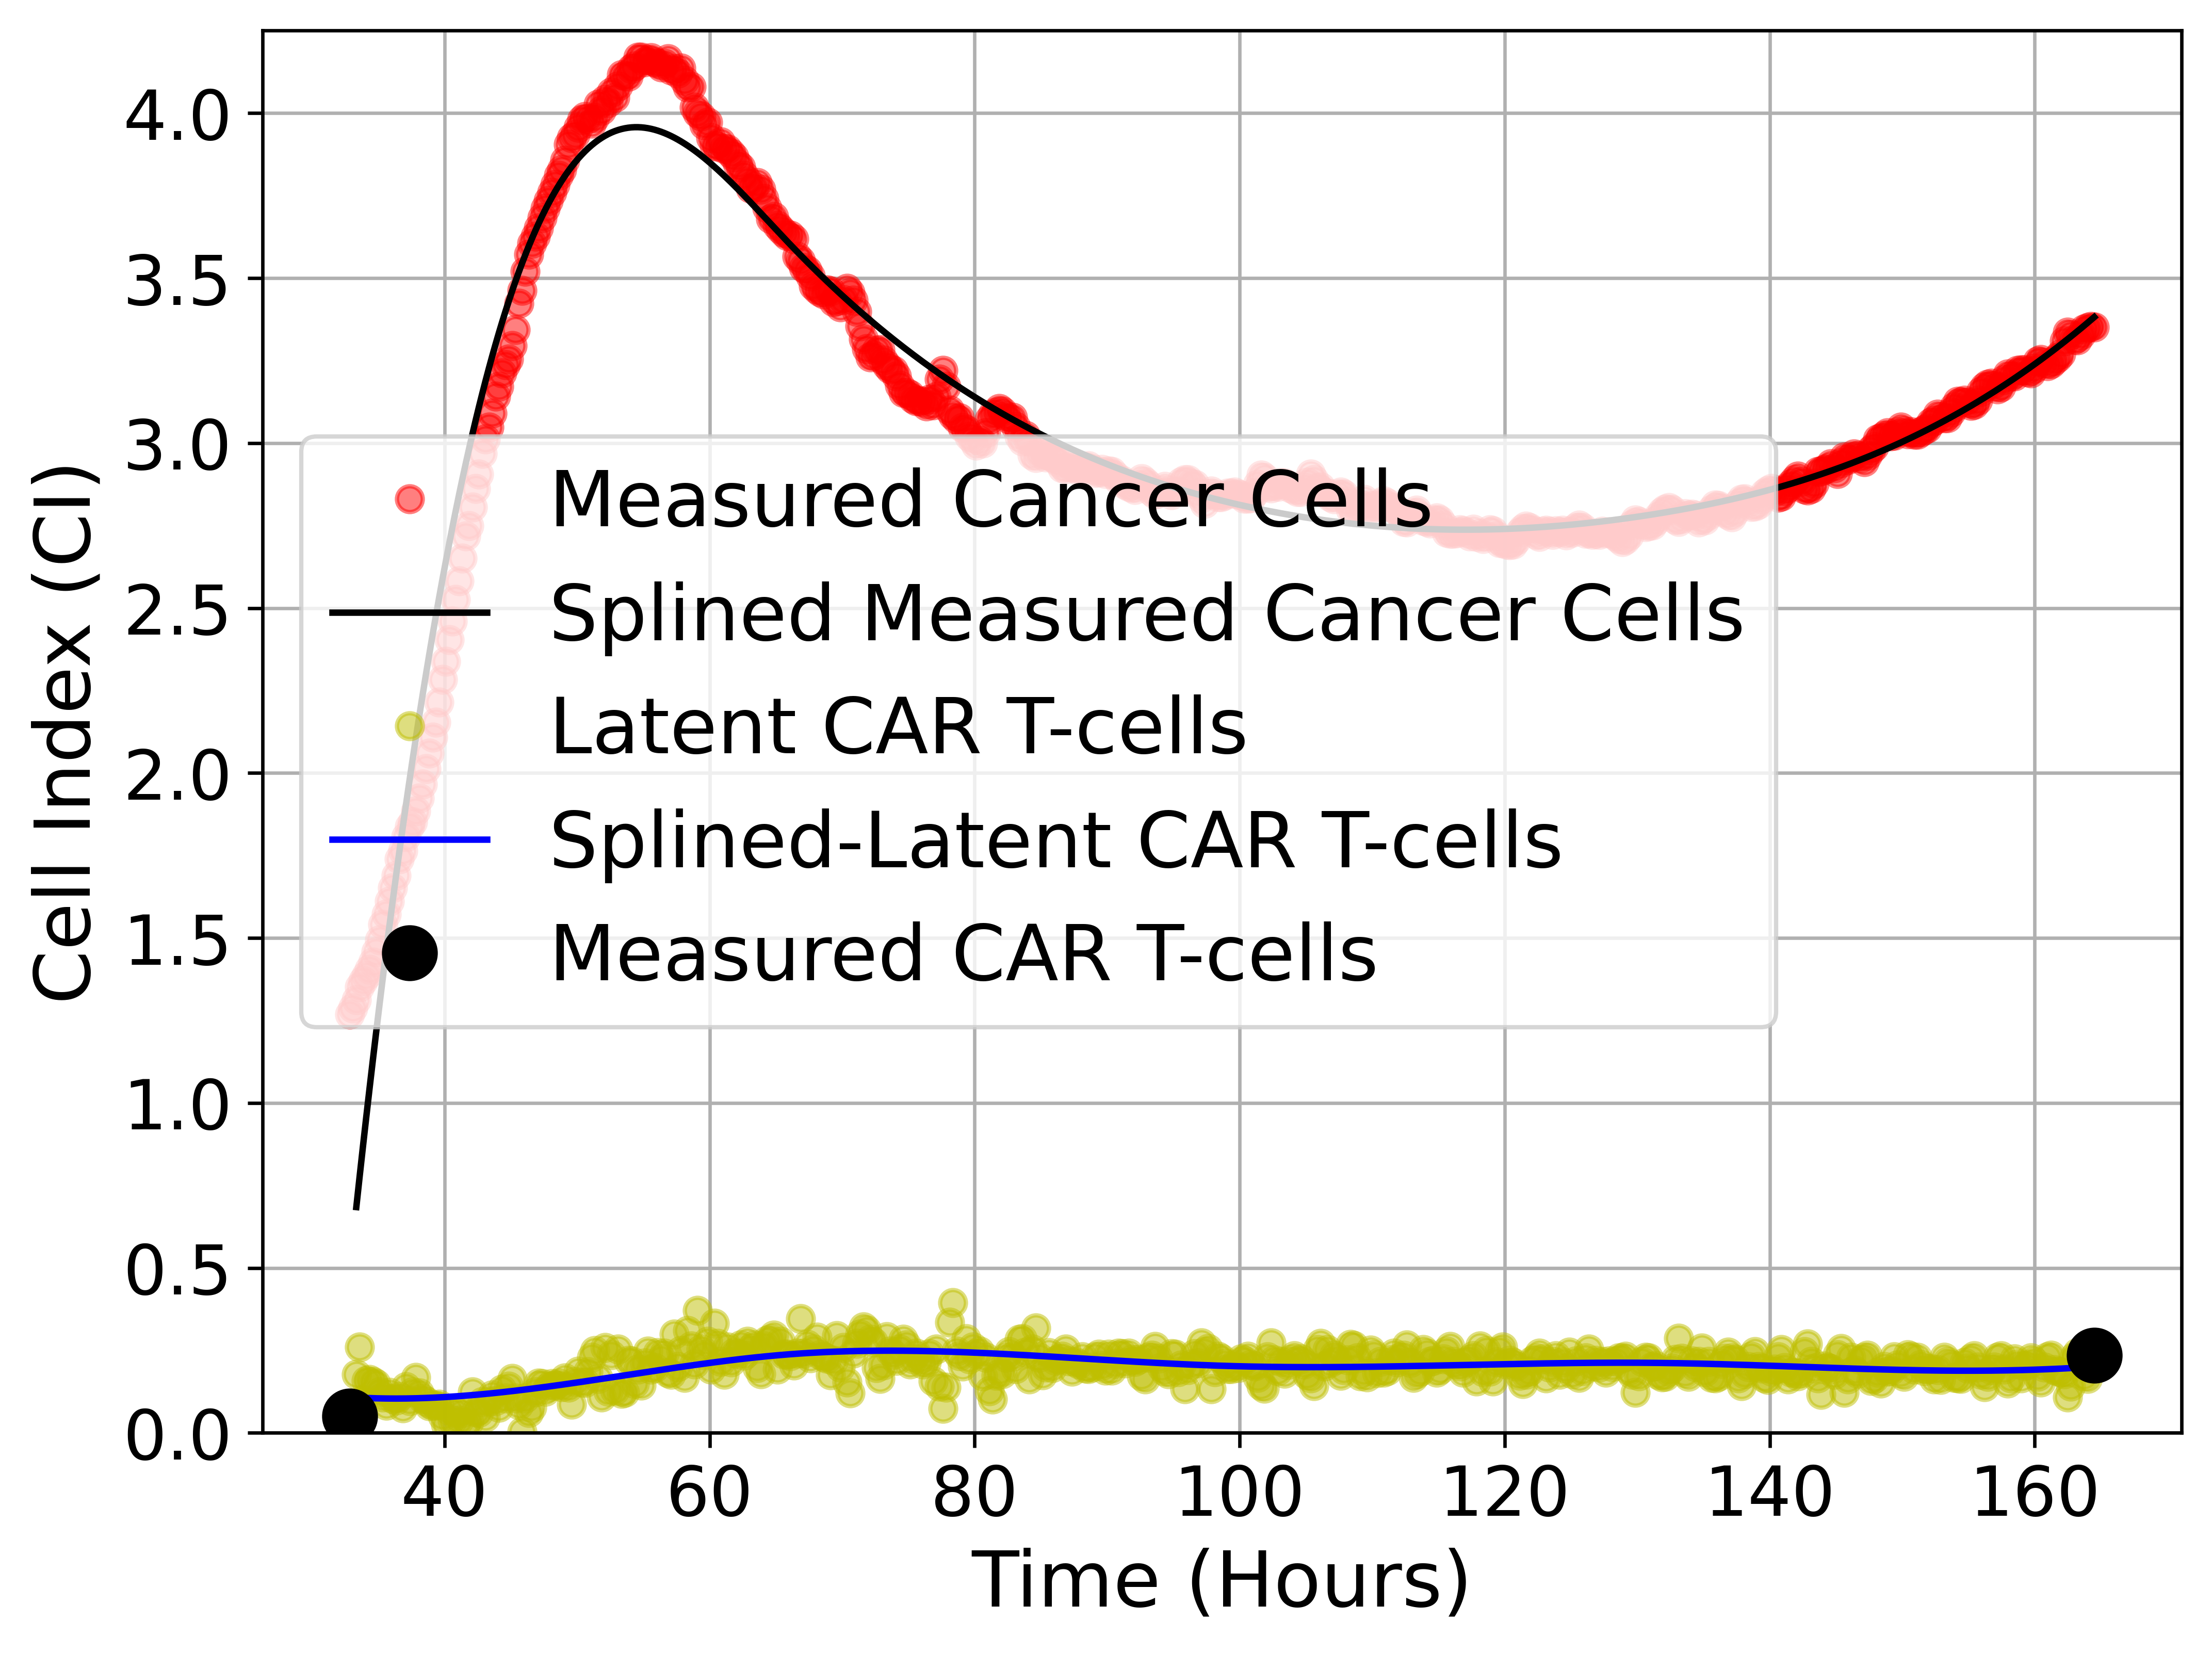

In [65]:
time, data = latent_discovery_spline(data_trajectories[:,0:,:], time_delay = 1, dimension = 2, nknots_arr = nknots_arr,
                                     t_cell_arr = t_cell_arr, invert_latent = invert_latent,
                                     cart_scale_arr = cart_scale_arr,
                                     cart_offset_arr = cart_offset_arr)
#latent_discovery_spline(np.array([data_trial1]), nknots_arr = np.array([[10,10]]))

In [66]:
### Generating pandas df of splined data for exporting to spreadsheets

trial1 = np.concatenate((np.array(time[0]).reshape(len(time[0]),1), np.array(data[0])), axis = 1)
trial2 = np.concatenate((np.array(time[1]).reshape(len(time[0]),1), np.array(data[1])), axis = 1)
np.concatenate((trial1, trial2), axis = 1)

pd_dataset = pd.DataFrame({'time_trial1_(hrs)': trial1[:, 0], 
                           'tumor_cells_trial1_(ci)': trial1[:, 1],
                          'cart_cells_trial1_(ci)': trial1[:,2],
                          'time_trial2_(hrs)': trial2[:, 0], 
                           'tumor_cells_trial2_(ci)': trial2[:, 1],
                          'cart_cells_trial2_(ci)': trial2[:,2]})
pd_dataset.to_csv('./splined_trajectories_ETratio_low.csv')